In [1]:
import torch
from diffusers import StableDiffusionXLPipeline, AutoencoderKL
from blora_utils import BLOCKS, filter_lora, scale_lora
import mediapy

vae_path = "../modelscope/sdxl-vae-fp16-fix"
vae = AutoencoderKL.from_pretrained(vae_path, torch_dtype=torch.float16)
sdxl_path = "../modelscope/stable-diffusion-xl-base-1.0"
pipeline = StableDiffusionXLPipeline.from_pretrained(
        sdxl_path,
        vae=vae,
        torch_dtype=torch.float16,
    ).to("cuda")

/mnt/d/anaconda3/envs/BLora/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/mnt/d/anaconda3/envs/BLora/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
def load_b_lora_to_unet(pipe, content_lora_model_id: str = '', style_lora_model_id: str = '', content_alpha: float = 1.,
                            style_alpha: float = 1.) -> None:
        try:
            # Get Content B-LoRA SD
            if content_lora_model_id:
                content_B_LoRA_sd, _ = pipe.lora_state_dict(content_lora_model_id)
                content_B_LoRA = filter_lora(content_B_LoRA_sd, BLOCKS['content'])
                content_B_LoRA = scale_lora(content_B_LoRA, content_alpha)
            else:
                content_B_LoRA = {}

            # Get Style B-LoRA SD
            if style_lora_model_id:
                style_B_LoRA_sd, _ = pipe.lora_state_dict(style_lora_model_id)
                style_B_LoRA = filter_lora(style_B_LoRA_sd, BLOCKS['style'])
                style_B_LoRA = scale_lora(style_B_LoRA, style_alpha)
            else:
                style_B_LoRA = {}

            # Merge B-LoRAs SD
            res_lora = {**content_B_LoRA, **style_B_LoRA}

            # Load
            pipe.load_lora_into_unet(res_lora, None, pipe.unet)
        except Exception as e:
            raise type(e)(f'failed to load_b_lora_to_unet, due to: {e}')

In [3]:
content_B_LoRA_path = 'output_dir/chicken_filled/pytorch_lora_weights.safetensors'
style_B_LoRA_path = 'output_dir/dog_lineal/pytorch_lora_weights.safetensors'
prompt = "Icon8. A chicken. minimal flat 2d icon. lineal color. on a white background. trending on artstation."

In [5]:
content_B_LoRA_sd, _ = pipeline.lora_state_dict(content_B_LoRA_path)

In [14]:
len(content_B_LoRA_sd)

320

In [10]:
content_B_LoRA = filter_lora(content_B_LoRA_sd, BLOCKS['content'])

In [13]:
len(content_B_LoRA)

160

  0%|          | 0/50 [00:00<?, ?it/s]

"content_alpha: 1.0, style_alpha: 1.0"

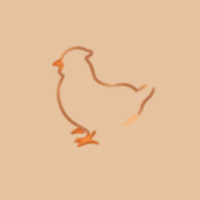

"content_alpha: 1.0, style_alpha: 1.0"

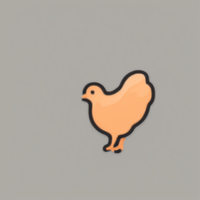

"content_alpha: 1.0, style_alpha: 1.0"

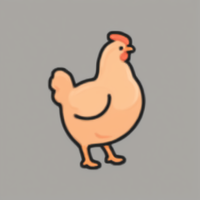

In [52]:
content_alpha, style_alpha= 1., 1.
load_b_lora_to_unet(pipeline, content_B_LoRA_path, style_B_LoRA_path, content_alpha, style_alpha)
image = pipeline(prompt, generator=torch.Generator(device="cuda").manual_seed(1234), num_images_per_prompt=3)

for img in image[0]:
    mediapy.show_image(img, width=200, height=200, title=f'content_alpha: {content_alpha}, style_alpha: {style_alpha}')

In [53]:
torch.cuda.empty_cache()